## Сессия 2

#### Импортирование библиотек

In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem import *
from __future__ import division
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import json
from sklearn.model_selection import learning_curve

### Формирование структуры набора данных

1 __TitleCompany__ - Название компании.

2 __Nominations__ - Номинации компаний.

3 __Reiting__ - Рейтинг компании.

4 __Categories__ - Категории компании.

5 __DatePublish__ - Дата опубликования статьи.

6 __TextPost__ - необработанный текст.

7 __TextPostLemat__ - обработанный, лемматизированный текст.

8 __TextPostToken__ - обработанный, токенизированный и лематизированный текст.

9 __bigram__ - биграммы обработанного и лемматизированного текста.

10 __trigram__ - триграммы обработанного и лемматизированного текста.

11 __keyword__ - ключевые слова обработанного и лемматизированного текста.

12 __NominationsToInt__ - Преобразованные номинации компаний в цифры.

## 2.1 Разбиение выборки

#### Методы обработки и лемматизации текста для проверки моделей

In [2]:
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem
import string
import re

In [3]:
# метод удаления пунктуации
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

# метод удаления чисел
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

# метод удаления двойных пробелов
def remove_multiple_spaces(text):
	return re.sub(r'\s+', ' ', text, flags=re.I)

# метод удаления оставшихся чисел
def remove_notalpha(text):
    return ''.join([i if i.isalpha() else ' ' for i in text])

# метод токенизирования
def tokenize(text):
    t = word_tokenize(text)
    return [token for token in t if token not in russian_stopwords]

# метод удаления слов < 3
def remove_small_text(text):
    words = text.split()
    return ' '.join([i if len(i) >=3 else ' ' for i in words])

# объект mystem для лематизации 
mystem = Mystem() 
# добавление стопслов
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'быть', 'r', 'n', 'а', 'мы', 'с', 'для', 'ещё', 'его', 'также', 'к', 'тем', 'кто', 'чтобы', 'но', 'они', 'будут', 'так', 'где', 'один', 'он ', 'и', 'на', 'но', 'или', 'либо', 'это', 'мб', 'далее', 'дв', 'свой', 'ваш','всё', 'очень', 'её', 'ещё', 'вообще', 'наш', 'который'])

In [4]:
def lemmatize(text):
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
        return text
    except Exception as e:
        print(e)

#### Обучение моделей

In [5]:
# чтение csv файла
dfHabr1 = pd.read_csv(r'C:\Users\МОиБД\Downloads\Report1.csv')

In [6]:
dfHabr1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TitleCompany     2017 non-null   object
 1   Reiting          2017 non-null   object
 2   DatePublish      2017 non-null   object
 3   TextPost         2017 non-null   object
 4   Categories       2017 non-null   object
 5   TextPostLemat    2017 non-null   object
 6   TextPostToken    2017 non-null   object
 7   bigram           2017 non-null   object
 8   trigram          2017 non-null   object
 9   keyword          2017 non-null   object
 10  count_matrix     2017 non-null   object
 11  Nominations      2017 non-null   object
 12  NomiantionToInt  2017 non-null   int64 
dtypes: int64(1), object(12)
memory usage: 205.0+ KB


In [7]:
# выбор целевой и обучающей переменной
X = dfHabr1['TextPostLemat']
y = dfHabr1['Nominations']

In [8]:
# деление на обучающие и тестовые переменные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

Выборка нужно делить на обучающую и тестовую для того, чтобы обучение не прошло просто так. То есть сначала идет обучение, потом проверка, и так он понимает, насколько хорошо обучился. Обычно на тестовую выборку оставляют 30% данных.

In [9]:
# вывод целевой переменной
my_tags = dfHabr1['Nominations'].unique()
my_tags

array(['Игровая индустрия и киберспорт', 'Наука, технологии и инновации',
       'Креативные индустрии', 'Здоровье и медицина',
       'Экономика и Бизнес', 'Образование и Кадры'], dtype=object)

MultinomialNB - это алгоритм классификации, который используется в машинном обучении для классификации текста и других данных с дискретными признаками. Он является вариантом алгоритма Naive Bayes, который основан на теореме Байеса и предположении о независимости между признаками. MultinomialNB особенно полезен для задач классификации текста, таких как фильтрация спама и анализ тональности текста. Алгоритм работает путем расчета вероятности каждого класса на основе входных признаков и выбора класса с наибольшей вероятностью в качестве выхода. В случае классификации текста входными признаками обычно являются частоты каждого слова в документе, а классы - это категории, на которые можно классифицировать документ. MultinomialNB реализован в библиотеке scikit-learn на Python, которая обеспечивает простой и эффективный интерфейс для обучения и использования алгоритма. MultinomialNB выбирается, когда распределение признаков дискретное

Ссылка на источник: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [10]:
# создание nb, которая будет сразу производить 3 действия с последовательностью, с помощью Pipeline
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [11]:
# обучение методом MultinomialNB
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [12]:
# предсказание и проверка предсказания
y_pred = nb.predict(X_test)

In [13]:
y_pred[0]

'Образование и Кадры'

In [14]:
my_tags

array(['Игровая индустрия и киберспорт', 'Наука, технологии и инновации',
       'Креативные индустрии', 'Здоровье и медицина',
       'Экономика и Бизнес', 'Образование и Кадры'], dtype=object)

In [15]:
# вывод точности модели и ее classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5643564356435643
                                precision    recall  f1-score   support

           Здоровье и медицина       0.92      0.29      0.44       121
Игровая индустрия и киберспорт       0.00      0.00      0.00         2
          Креативные индустрии       0.00      0.00      0.00        73
 Наука, технологии и инновации       0.47      1.00      0.64       203
           Образование и Кадры       0.77      0.58      0.66       181
            Экономика и Бизнес       0.00      0.00      0.00        26

                      accuracy                           0.56       606
                     macro avg       0.36      0.31      0.29       606
                  weighted avg       0.57      0.56      0.50       606



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SGDClassifier - это алгоритм классификации, который использует стохастический градиентный спуск для обучения модели. Он является одним из наиболее эффективных алгоритмов для решения крупномасштабных и разреженных задач машинного обучения, часто встречающихся при классификации текста и обработке естественного языка. Алгоритм работает путем минимизации функции потерь с помощью градиентного спуска, который обновляет веса модели на каждом шаге, используя только один случайный пример из обучающего набора за раз. Это позволяет SGDClassifier обучаться на больших наборах данных быстрее, чем другие алгоритмы, такие как логистическая регрессия и SVM. В библиотеке scikit-learn на Python реализован SGDClassifier, который обеспечивает простой и эффективный интерфейс для обучения и использования алгоритма

Ссылка на источник: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [16]:
# создание sgd, которая будет сразу производить 3 действия с последовательностью, с помощью Pipeline
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

In [17]:
# обучение методом SGDClassifier
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [18]:
# предсказание и проверка предсказания
y_pred = sgd.predict(X_test)

In [19]:
# вывод точности модели и ее classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7887788778877888
                                precision    recall  f1-score   support

           Здоровье и медицина       0.67      0.79      0.72       121
Игровая индустрия и киберспорт       0.00      0.00      0.00         2
          Креативные индустрии       0.92      0.81      0.86        73
 Наука, технологии и инновации       0.79      0.85      0.82       203
           Образование и Кадры       0.84      0.76      0.80       181
            Экономика и Бизнес       0.82      0.54      0.65        26

                      accuracy                           0.79       606
                     macro avg       0.67      0.62      0.64       606
                  weighted avg       0.79      0.79      0.79       606



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression - это алгоритм машинного обучения, который используется для решения задач бинарной классификации, то есть разделения данных на два класса. Он основан на линейной регрессии и использует логистическую функцию для преобразования выхода в вероятность принадлежности к классу. Логистическая регрессия хорошо подходит для задач, в которых требуется определить, принадлежит ли объект к определенному классу или нет, например, для определения склонности к депрессии. В библиотеке scikit-learn на Python реализована логистическая регрессия, которая обеспечивает простой и эффективный интерфейс для обучения и использования алгоритма. Логистическая регрессия также может использоваться для многоклассовой классификации, когда требуется разделить данные на более чем два класса

Ссылка на источник: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [20]:
# создание logreg, которая будет сразу производить 3 действия с последовательностью, с помощью Pipeline
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])

In [21]:
# обучение методом LogisticRegression
logreg.fit(X_train, y_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [22]:
# предсказание и проверка предсказания
y_pred = logreg.predict(X_test)

In [23]:
# вывод точности модели и ее classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7904290429042904
                                precision    recall  f1-score   support

           Здоровье и медицина       0.66      0.80      0.73       121
Игровая индустрия и киберспорт       0.00      0.00      0.00         2
          Креативные индустрии       0.90      0.82      0.86        73
 Наука, технологии и инновации       0.82      0.84      0.83       203
           Образование и Кадры       0.85      0.77      0.81       181
            Экономика и Бизнес       0.71      0.46      0.56        26

                      accuracy                           0.79       606
                     macro avg       0.66      0.62      0.63       606
                  weighted avg       0.80      0.79      0.79       606



Выбрана лучшая модель классификации LogisticRegression т.к. по показателям точности она лучше всего и по моему мнению для данной задачи подходит лучше всего. Так что дальнейшая работа будет проводиться с ней.

## 2.2 Оптимизация модели

In [24]:
dfHabr1.head()

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword,count_matrix,Nominations,NomiantionToInt
0,Cybersport.Metaratings,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"['декабрь', 'состояться', 'церемония', 'награж...","[('декабрь', 'состояться'), ('состояться', 'це...","[('декабрь', 'состояться', 'церемония'), ('сос...","номинация, проект, москва, премия, рунет, разв...","(0, 224)\t1\n (0, 838)\t1\n (0, 966)\t1\n ...",Игровая индустрия и киберспорт,0
1,ESforce Holding,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"['декабрь', 'состояться', 'церемония', 'награж...","[('декабрь', 'состояться'), ('состояться', 'це...","[('декабрь', 'состояться', 'церемония'), ('сос...","номинация, проект, москва, премия, рунет, разв...","(0, 224)\t1\n (0, 838)\t1\n (0, 966)\t1\n ...",Игровая индустрия и киберспорт,0
2,ESforce Holding,Пусто,29 июля,Из совместного исследования издателя компьютер...,Пусто,совместный исследование издатель компьютерный ...,"['совместный', 'исследование', 'издатель', 'ко...","[('совместный', 'исследование'), ('исследовани...","[('совместный', 'исследование', 'издатель'), (...","игра, год, world, серия, геймер, популярный, ф...","(0, 591)\t3\n (0, 335)\t3\n (0, 327)\t2\n ...",Игровая индустрия и киберспорт,0
3,ESforce Holding,Пусто,9 июля,По статистике The Esports Observer за I полови...,Пусто,статистика the esports observer половина год в...,"['статистика', 'the', 'esports', 'observer', '...","[('статистика', 'the'), ('the', 'esports'), ('...","[('статистика', 'the', 'esports'), ('the', 'es...","млн, канал, dota, ruhub, год, просмотр, место,...","(0, 634)\t1\n (0, 138)\t1\n (0, 44)\t1\n ...",Игровая индустрия и киберспорт,0
4,ESforce Holding,Пусто,11 апреля,Компании SuperData Research и PayPal провели с...,Пусто,компания superdata research paypal проводить с...,"['компания', 'superdata', 'research', 'paypal'...","[('компания', 'superdata'), ('superdata', 'res...","[('компания', 'superdata', 'research'), ('supe...","киберспорт, миллион, год, рынок, superdata, кр...","(0, 506)\t6\n (0, 84)\t7\n (0, 65)\t6\n (...",Игровая индустрия и киберспорт,0


Для уменьшения вычислительной сложности необходимо выбрать значимые признаки и понизить размерность, но я считаю, что этого делать не нужно, т.к. датафрейм и так маленький и обучение работает довольно быстроэ. В общем этих записей не настолько много, чтобы уменьшить вычислительную мощность

In [25]:
econ_text = 'Многие из нас ежедневно пользуются поисковыми.'

In [26]:
# обработка текста с токенизацией
econ_text = remove_multiple_spaces(lemmatize(remove_small_text(remove_notalpha(remove_numbers(remove_punctuation(econ_text))))))

In [28]:
# запуск модели
ect_pred = nb.predict([econ_text])
ect_pred

array(['Наука, технологии и инновации'], dtype='<U30')

In [85]:
econ_text1 = 'Многие из нас ежедневно пользуются поисковыми.'

In [86]:
# обработка текста без токенизации и лематизации для отдельной колонки с лематизацией
econ_text1 = remove_multiple_spaces(lemmatize(remove_small_text(remove_notalpha(remove_numbers(remove_punctuation(econ_text1))))))

In [88]:
ect_pred1 = sgd.predict([econ_text1])
ect_pred1

array(['Креативные индустрии'], dtype='<U30')

In [32]:
econ_text2 = 'Многие из нас ежедневно пользуются поисковыми.'

In [33]:
# обработка текста без токенизации и лематизации для отдельной колонки с лематизацией
econ_text2 = remove_multiple_spaces(lemmatize(remove_small_text(remove_notalpha(remove_numbers(remove_punctuation(econ_text2))))))

In [34]:
ect_pred2 = logreg.predict([econ_text2])
ect_pred2

array(['Креативные индустрии'], dtype=object)

Модель logreg и sgd показали себя хорошо, но по показателю точности logreg лучше, так что будет использоваться модель logreg без проблем.

#### Подбор гипперпараметров для улучшения модели

In [35]:
# создание logreg, которая будет сразу производить 3 действия с последовательностью, с помощью Pipeline
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e4)),
               ])

In [36]:
# обучение методом LogisticRegression
logreg.fit(X_train, y_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=10000.0, n_jobs=1))])

In [37]:
# предсказание и проверка предсказания
y_pred = logreg.predict(X_test)

In [38]:
# вывод точности модели и ее classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7887788778877888
                                precision    recall  f1-score   support

           Здоровье и медицина       0.68      0.80      0.74       121
Игровая индустрия и киберспорт       0.00      0.00      0.00         2
          Креативные индустрии       0.88      0.79      0.83        73
 Наука, технологии и инновации       0.81      0.83      0.82       203
           Образование и Кадры       0.83      0.79      0.81       181
            Экономика и Бизнес       0.79      0.42      0.55        26

                      accuracy                           0.79       606
                     macro avg       0.67      0.61      0.63       606
                  weighted avg       0.80      0.79      0.79       606



In [104]:
econ_text = 'Водный баланс - необходим'

In [105]:
# обработка текста без токенизации и лематизации для отдельной колонки с лематизацией
econ_text = remove_multiple_spaces(lemmatize(remove_small_text(remove_notalpha(remove_numbers(remove_punctuation(econ_text))))))

In [106]:
# запуск модели
ect_pred = logreg.predict([econ_text])
ect_pred

array(['Образование и Кадры'], dtype=object)

При подборе гипперпараметров модель улучшилась, но несильно, она либо улучшается совсем чуть-чуть, либо остается на таком же уровне, либо сильно падает, но 0,811 уже хороший результат.

Также при большем количество данных модель показала себя лучше всего, поэтому я не стал оставлять понижение размерности, т.к. обучение все равно проходит очень быстро и это не нужно (понижение размерности нужно для ускорения работы).

#### Кривые валидации и обучения

In [42]:
# создание тренировочных меток на основе модели LogReg и данных использующих этой моделью
train_sizes, train_scores, test_scores = learning_curve(
    logreg, X, y, cv=5, scoring='accuracy', n_jobs=-1)

In [43]:
# запись средних значения и стандартных отклонений, для построения кривых
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

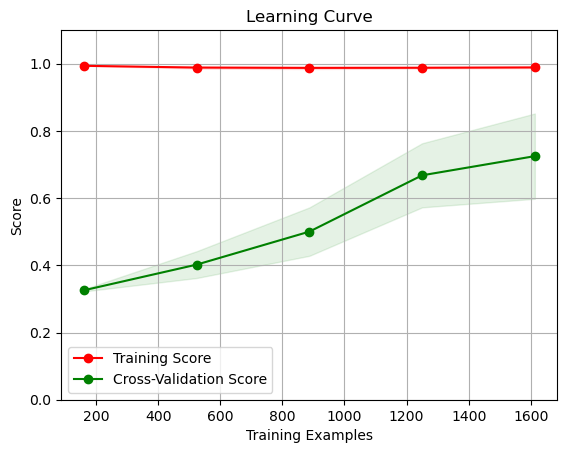

In [44]:
# само построение
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
         label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
         label='Cross-Validation Score')
plt.legend(loc='best')
plt.show()

In [45]:
# сохраняем DataFrame в файл
dfHabr1.to_csv(r'C:\Users\МОиБД\Downloads\Report2.csv', index=False, encoding='utf-8')

## 2.3 Подготовка отчета




__2.1 Разбиение выборки__ Пункт был выполнен без нареканий. Было выполнено обучение и тестовая выборка, разделились 70 на 30%. Модель я выбрал LogisticRegression, сама модель с неплохой точностью (0,808). Обучение модели проходило на необработанном тексте и номинациях. 

    __2.1.1 SGDClassifier__  пользовался моделью, так как модель показывает себя очень хорошо (точность 0,806), в данном случае это было так, но она показала себя чуть хуже, чем LogisticRegression (Бинарная классификация).
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

    __2.1.2 LogisticRegression__ выбрал, так как при обучении и тестовой выборке показала лучшую точность (0,808), так же полезна по другим вещам. 
    https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

    __2.1.3 MultinomialNB__ сама модель хорошая, но не в данной ситуцации, потому что она подходит немного для других вещей поэтому показала довольно скудную точность.
    https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    
__2.2  Оптимизация модели__ Пункт был выполнен успешно. Была выполнена подборка гипперпараметров для модели LogisticRegression и ее точность улучшилась на 0,03. Сам результат получился неплохим, т.к. гипперпараметры в принципе редко сильно повышают точность модели. Также были выведены графики кривых валидаций и обучения, они показали себя хорошо.

__2.3 Подготовка отчета__ Предварительная обработка данных выполнена полностью, без проблем.

### Вывод

В итоге работа была полностью выполнена. 